<a href="https://colab.research.google.com/github/chandini2595/FireSense/blob/main/Colab_Files/DS1_FeatureImportance_Amalgamation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Load the dataset
file_path = "/content/ds1.csv"
df = pd.read_csv(file_path)

# Display basic info about the dataset
print("Dataset Info:")
print(df.info())

# Show the first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB
None

First 5 rows of the dataset:
   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  

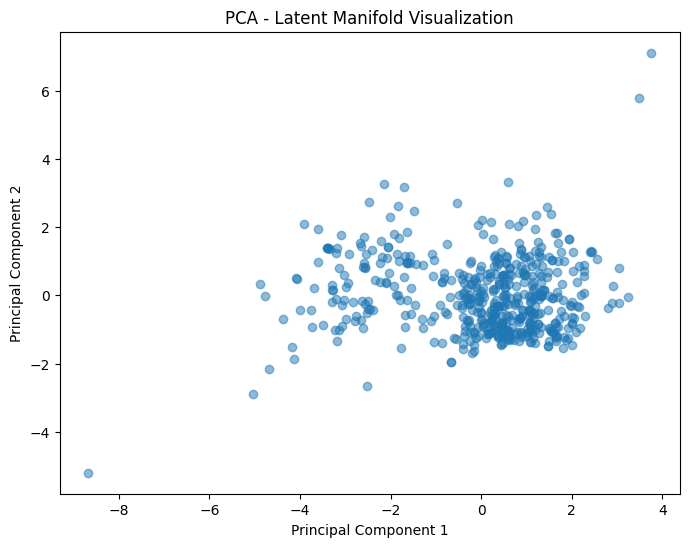

Explained variance ratio: [0.34458275 0.15290179]
Total variance explained by first 2 components: 0.50


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Selecting only numerical columns for PCA
numerical_cols = df.select_dtypes(include=['float64']).columns
X = df[numerical_cols]

# Standardizing the data (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=2)  # Reduce to 2D for visualization
X_pca = pca.fit_transform(X_scaled)

# Scatter plot of the reduced dimensions
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA - Latent Manifold Visualization")
plt.show()

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)
print(f"Total variance explained by first 2 components: {sum(explained_variance):.2f}")

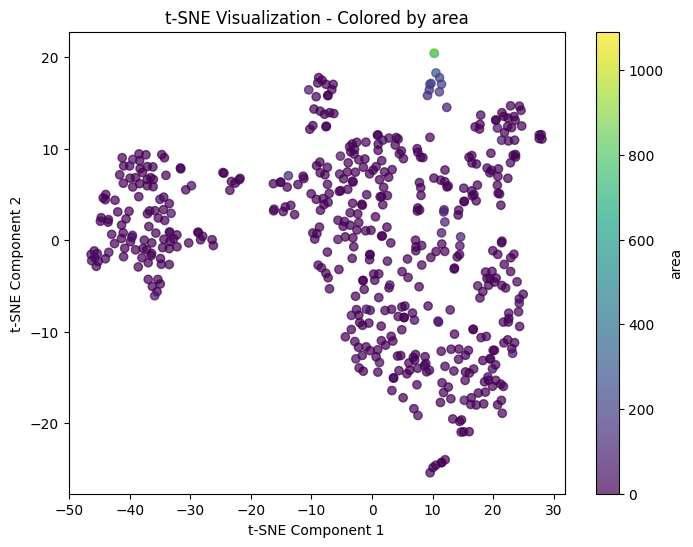

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Choosing an alternative feature for coloring
color_feature = 'area'  # Change this to any feature you want to explore

# Applying t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# Scatter plot of t-SNE transformed data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7, c=df[color_feature], cmap='viridis')
plt.colorbar(label=color_feature)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title(f"t-SNE Visualization - Colored by {color_feature}")
plt.show()

Available columns in dataset:
 Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area', 'tsne_1', 'tsne_2'],
      dtype='object')


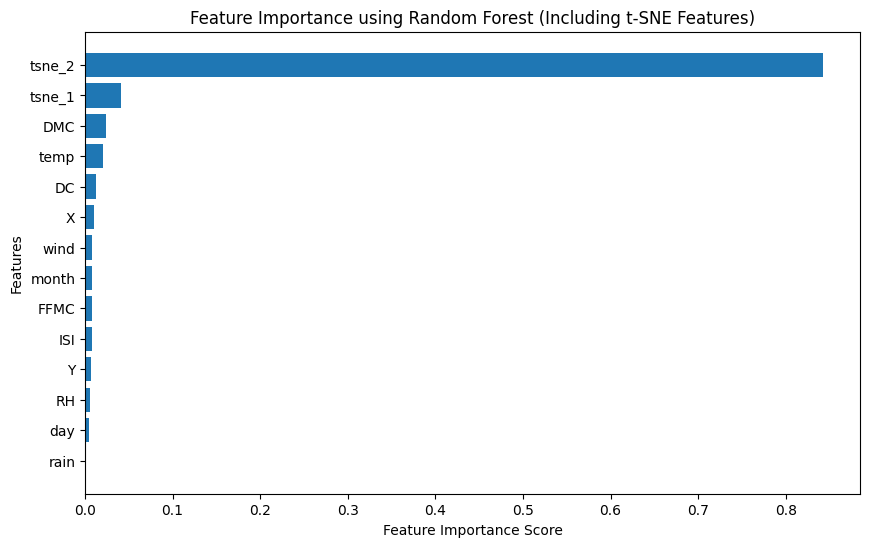

Top Features Influencing Wildfire Burned Area:
   Feature  Importance
13  tsne_2    0.842692
12  tsne_1    0.040615
5      DMC    0.024287
8     temp    0.020549
6       DC    0.012627
0        X    0.009712
10    wind    0.008256
2    month    0.008093
4     FFMC    0.007780
7      ISI    0.007479


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Check available columns before feature selection
print("Available columns in dataset:\n", df.columns)

# Ensure t-SNE features exist
if 'tsne_1' not in df.columns or 'tsne_2' not in df.columns:
    raise KeyError("t-SNE features ('tsne_1', 'tsne_2') are missing. Run t-SNE before selecting features.")

# Encode categorical variables ('month' and 'day')
label_encoder_month = LabelEncoder()
label_encoder_day = LabelEncoder()

df['month'] = label_encoder_month.fit_transform(df['month'])
df['day'] = label_encoder_day.fit_transform(df['day'])

# Define features (including t-SNE features)
feature_cols = ['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'tsne_1', 'tsne_2']
X = df[feature_cols]
y = df['area']  # Target variable (burned area)

# Train a Random Forest model to assess feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importances
feature_importances = pd.DataFrame({'Feature': feature_cols, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance using Random Forest (Including t-SNE Features)")
plt.gca().invert_yaxis()
plt.show()

# Print top features
print("Top Features Influencing Wildfire Burned Area:")
print(feature_importances.head(10))

In [29]:
# Selecting important features based on Random Forest ranking
important_features = feature_importances[feature_importances['Importance'] > 0.010]['Feature'].tolist()
df_selected = df[important_features + ['area']]  # Keeping target variable

# Display updated dataset with selected features
print("Selected Features for Modeling:", important_features)
print("\nUpdated Dataset Shape:", df_selected.shape)

Selected Features for Modeling: ['tsne_2', 'tsne_1', 'DMC', 'temp', 'DC']

Updated Dataset Shape: (517, 6)


In [31]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = df_selected.drop(columns=['area'])
y = df_selected['area']

# Splitting data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirm split sizes
print(f"Training Data Shape: {X_train.shape}, Testing Data Shape: {X_test.shape}")

Training Data Shape: (413, 5), Testing Data Shape: (104, 5)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1094.9932 - mae: 14.8577 - val_loss: 12056.6523 - val_mae: 23.5142
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1477.1089 - mae: 13.2499 - val_loss: 11905.0732 - val_mae: 28.4785
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1043.8813 - mae: 14.2341 - val_loss: 11878.7197 - val_mae: 31.5536
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1957.0439 - mae: 21.6806 - val_loss: 12087.5781 - val_mae: 22.9364
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1555.9795 - mae: 14.7514 - val_loss: 11889.2168 - val_mae: 26.1400
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2041.4552 - mae: 15.0642 - val_loss: 11893.2305 - val_mae: 25.5640
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4522.6211 - mae: 20.8723 - val_loss: 12163.8711 - val_mae: 23.2930
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 929.3311 - mae: 11.9158 - val_loss: 11767.4746 - val_mae: 28.5883
Epoch 9

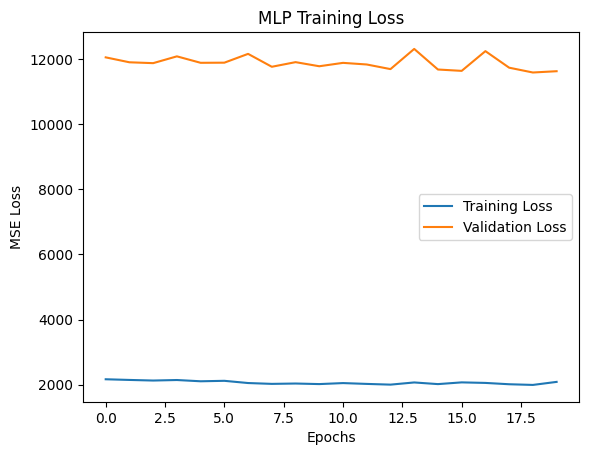

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define MLP model
mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
mlp_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Plot training loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("MLP Training Loss")
plt.show()

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - MSE: {mse_lr:.2f}, R² Score: {r2_lr:.2f}")

Linear Regression - MSE: 11342.89, R² Score: 0.04


In [34]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MSE: {mse_rf:.2f}, R² Score: {r2_rf:.2f}")

Random Forest - MSE: 3096.90, R² Score: 0.74


In [35]:
from sklearn.neighbors import KNeighborsRegressor

# Train KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict on test set
y_pred_knn = knn_model.predict(X_test)

# Evaluate performance
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"KNN Regressor - MSE: {mse_knn:.2f}, R² Score: {r2_knn:.2f}")

KNN Regressor - MSE: 10489.89, R² Score: 0.11


In [36]:
from xgboost import XGBRegressor

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - MSE: {mse_xgb:.2f}, R² Score: {r2_xgb:.2f}")

XGBoost - MSE: 1367.98, R² Score: 0.88


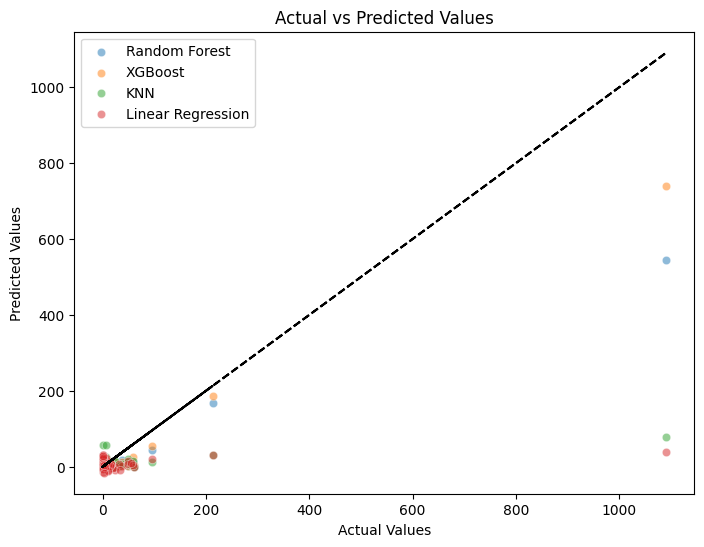

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for visualization
results = pd.DataFrame({
    "Actual": y_test,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb,
    "KNN": y_pred_knn,
    "Linear Regression": y_pred_lr
})

# Plot predictions vs actual values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=results["Actual"], y=results["Random Forest"], label="Random Forest", alpha=0.5)
sns.scatterplot(x=results["Actual"], y=results["XGBoost"], label="XGBoost", alpha=0.5)
sns.scatterplot(x=results["Actual"], y=results["KNN"], label="KNN", alpha=0.5)
sns.scatterplot(x=results["Actual"], y=results["Linear Regression"], label="Linear Regression", alpha=0.5)
plt.plot(results["Actual"], results["Actual"], color='black', linestyle='dashed')  # Perfect predictions line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()

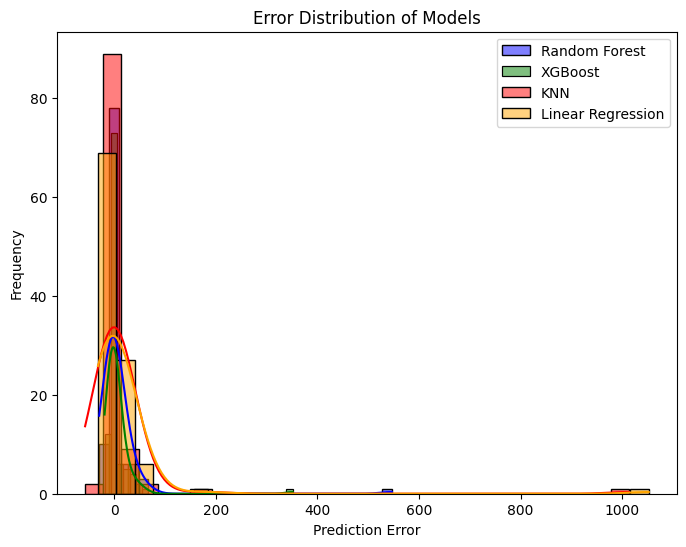

In [38]:
# Calculate errors
errors_rf = y_test - y_pred_rf
errors_xgb = y_test - y_pred_xgb
errors_knn = y_test - y_pred_knn
errors_lr = y_test - y_pred_lr

# Plot error distribution
plt.figure(figsize=(8, 6))
sns.histplot(errors_rf, bins=30, label="Random Forest", kde=True, color="blue")
sns.histplot(errors_xgb, bins=30, label="XGBoost", kde=True, color="green")
sns.histplot(errors_knn, bins=30, label="KNN", kde=True, color="red")
sns.histplot(errors_lr, bins=30, label="Linear Regression", kde=True, color="orange")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution of Models")
plt.legend()
plt.show()

#Classification


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Create a copy of the dataset
df_classification = df.copy()

# Convert 'area' into a binary classification target
df_classification['fire_occurred'] = (df_classification['area'] > 0).astype(int)  # 1 if fire occurred, 0 otherwise

# Encode categorical features ('month' and 'day')
label_encoder_month = LabelEncoder()
label_encoder_day = LabelEncoder()

df_classification['month'] = label_encoder_month.fit_transform(df_classification['month'])
df_classification['day'] = label_encoder_day.fit_transform(df_classification['day'])

# Define features (excluding original 'area' column)
X = df_classification.drop(columns=['area', 'fire_occurred'])  # Remove 'area' and target variable
y = df_classification['fire_occurred']  # Target variable

# Split into training and test sets (80% train, 20% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print class distribution in training set
print("Class distribution in training set:\n", y_train.value_counts(normalize=True))

Class distribution in training set:
 fire_occurred
1    0.523002
0    0.476998
Name: proportion, dtype: float64


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Train Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("AUC-ROC Score:", roc_auc_score(y_test, y_prob_lr))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.61      0.46      0.52        50
           1       0.59      0.72      0.65        54

    accuracy                           0.60       104
   macro avg       0.60      0.59      0.59       104
weighted avg       0.60      0.60      0.59       104

AUC-ROC Score: 0.6192592592592593


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("AUC-ROC Score:", roc_auc_score(y_test, y_prob_rf))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        50
           1       0.67      0.67      0.67        54

    accuracy                           0.65       104
   macro avg       0.65      0.65      0.65       104
weighted avg       0.65      0.65      0.65       104

AUC-ROC Score: 0.7487037037037036


In [43]:
from sklearn.neighbors import KNeighborsClassifier

# Train KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_knn = knn_model.predict(X_test)
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]

print("KNN Results:")
print(classification_report(y_test, y_pred_knn))
print("AUC-ROC Score:", roc_auc_score(y_test, y_prob_knn))

KNN Results:
              precision    recall  f1-score   support

           0       0.70      0.66      0.68        50
           1       0.70      0.74      0.72        54

    accuracy                           0.70       104
   macro avg       0.70      0.70      0.70       104
weighted avg       0.70      0.70      0.70       104

AUC-ROC Score: 0.7116666666666667


In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define MLP model
mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile model
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
mlp_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict and evaluate
y_prob_mlp = mlp_model.predict(X_test).flatten()
y_pred_mlp = (y_prob_mlp > 0.5).astype(int)

print("MLP Neural Network Results:")
print(classification_report(y_test, y_pred_mlp))
print("AUC-ROC Score:", roc_auc_score(y_test, y_prob_mlp))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4684 - loss: 22.6515 - val_accuracy: 0.5192 - val_loss: 4.2987
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5421 - loss: 3.6999 - val_accuracy: 0.5481 - val_loss: 3.4437
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5084 - loss: 3.5190 - val_accuracy: 0.5577 - val_loss: 2.8345
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5433 - loss: 2.6184 - val_accuracy: 0.5577 - val_loss: 1.9110
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5492 - loss: 2.2194 - val_accuracy: 0.5673 - val_loss: 1.9145
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5578 - loss: 1.5495 - val_accuracy: 0.4712 - val_loss: 1.2576
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5632 - loss: 0.9527 - val_accuracy: 0.5385 - val_loss: 1.0411
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5678 - loss: 1.0141 - val_accuracy: 0.5385 - val_loss: 1.0602
E

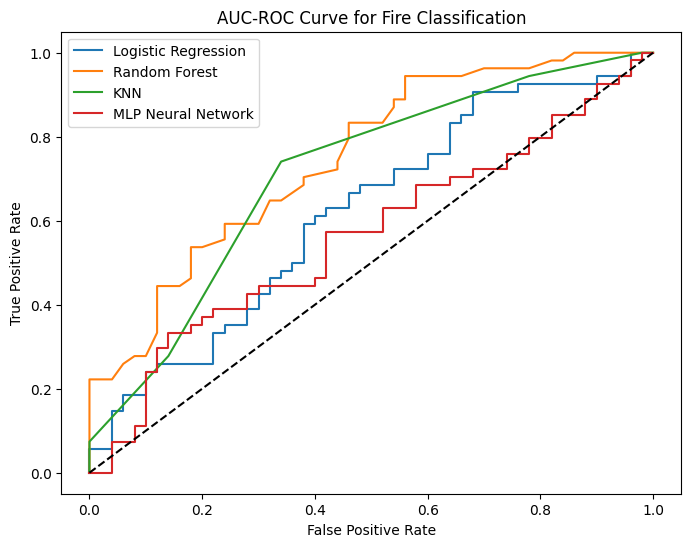

In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot(fpr_knn, tpr_knn, label="KNN")
plt.plot(fpr_mlp, tpr_mlp, label="MLP Neural Network")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for Fire Classification")
plt.legend()
plt.show()

In [52]:
import pandas as pd

# Store classification results in a DataFrame
classification_results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "KNN",  "MLP Neural Network"],
    "Accuracy": [
        lr_model.score(X_test, y_test),
        rf_model.score(X_test, y_test),
        knn_model.score(X_test, y_test),
        mlp_model.evaluate(X_test, y_test, verbose=0)[1]
    ],
    "Precision": [
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_knn, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_mlp, output_dict=True)['1']['precision'],
    ],
    "Recall": [
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_knn, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_mlp, output_dict=True)['1']['recall'],
    ],
    "F1-score": [
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_knn, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_mlp, output_dict=True)['1']['f1-score'],
    ],
    "AUC-ROC": [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_knn),
        roc_auc_score(y_test, y_prob_mlp),
    ]
})
# Transpose the DataFrame to have models as columns and metrics as rows
classification_results_transposed = classification_results.set_index("Model").T

# Display the transposed DataFrame
from IPython.display import display
display(classification_results_transposed)

Model,Logistic Regression,Random Forest,KNN,MLP Neural Network
Accuracy,0.596154,0.653846,0.701923,0.576923
Precision,0.590909,0.666667,0.701754,0.678571
Recall,0.722222,0.666667,0.740741,0.351852
F1-score,0.650000,0.666667,0.720721,0.463415
AUC-ROC,0.619259,0.748704,0.711667,0.563704


<Figure size 1000x500 with 0 Axes>

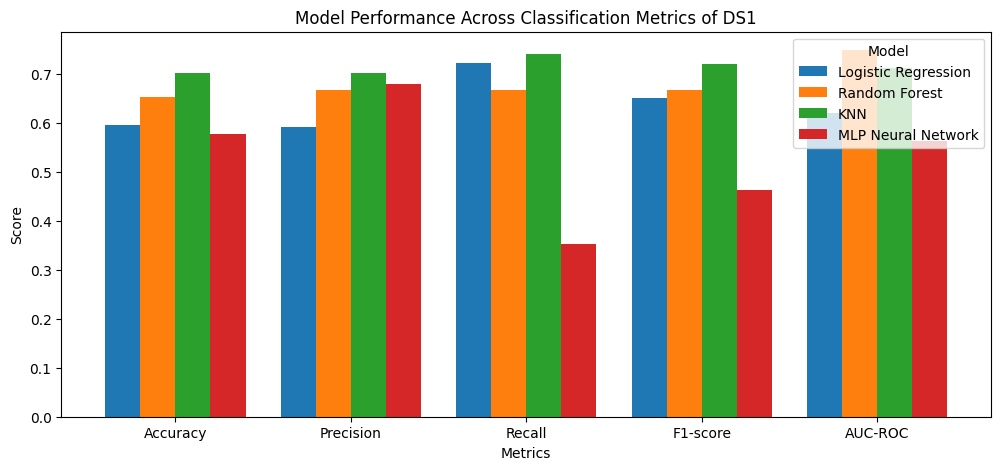

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Transpose DataFrame to have models as columns and metrics as rows
classification_results_transposed = classification_results.set_index("Model").T

# Plot the results
plt.figure(figsize=(10, 5))
classification_results_transposed.plot(kind="bar", figsize=(12, 5), width=0.8)

plt.title("Model Performance Across Classification Metrics of DS1")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.xticks(rotation=0)
plt.legend(title="Model", loc="upper right")

plt.show()